<a href="https://colab.research.google.com/github/GeorgeC0503/GC_010-Element-Coursework/blob/main/Systems_Biology_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import PACKAGES These dependencies are required to run the following code

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
import pandas as pd
from scipy.optimize import curve_fit, minimize
from scipy.integrate import odeint
from scipy.stats import pearsonr
import networkx as nx
import seaborn as sns

In [ ]:
# Load the CSV file into a numpy array. This first data file contains
# "Stir tank reactor" (STR) timepoint data. Files must be in the
# colab environment

def import_csv_files (online_data, offline_data):
    # Inputs data from supplied file bath (online_data)
    # Firstly I imported the data with the header.
    run_data_plus_header = np.genfromtxt(str(online_data), delimiter=','
                            , dtype='str')
    # For use later in the program its more beneficial to remove the header
    run_data = run_data_plus_header[1:, :]
    # Ensuring data has been imported properly and gaining info about the dataset
    print("Online data table length = ", str(len(run_data)))
    print("Online data layout = ", run_data)
    # Load the CSV file into a numpy array. This second data file contains
    # offline Optical Density (OD) data


    #Imports data from supplied file path for (offline_data)
    sample_data = np.genfromtxt(str(offline_data), delimiter=',',
                            skip_header=1, dtype='str')
    # Check format of sample_data.
    print(sample_data)

    return run_data, run_data_plus_header, sample_data


# ----> ONLY RUN IF FINAL SAMPLE WAS MEASURE AFTER THE LOG IS STOPPED <---
def add_footer_row (online_data, offline_data):
  # Creates np.array to act as the placeholder for editing -> final row.
  new_bottom_row = np.zeros((1, offline_data.shape[1]))

  # This line changes the first value of the "new_bottom_row" np.array to match
  # the highest timestamp listed in the offline OD data.
  new_bottom_row[0, 0] = sample_data [-1, 0]
  print(new_bottom_row)

  # Concatenate new row np.array to the bottom of the run_data 2D array.
  offline_data = np.concatenate((offline_data, new_bottom_row), axis=0)

  return offline_data


online_data_path = '/content/IF1840 DATA.csv'
offline_data_path = '/content/IF1840 OD data.csv'

run_data, run_data_plus_header, sample_data = import_csv_files(str(online_data_path), str(offline_data_path))

# To pair offline Optical Density data to the runtime data we must
# introduce a 0 hr row as the runtime data (STR) doesnt log a 0hr timestamp
new_top_row = np.zeros((1, run_data.shape[1]))

# Concatenate the new row "zero" to the beginning of the array
run_data = np.concatenate((new_top_row, run_data), axis=0)

# ---> If the OD data for the final sample (time in hrs) was taken after the STR
# program was halted, values (and therefore timestamped rows in the log) will
# not be present. Therefore we have to add a final footer row. <---
if sample_data [-1, 0] > run_data [-1, 0]:
  run_data = add_footer_row(sample_data, run_data)

Online data table length =  2278
Online data layout =  [['0.001027778' '99.80000305' '600' ... '45970.48047' '0' '0']
 ['0.016722222' '99.69999695' '600' ... '46920.48047' '0' '0']
 ['0.033472222' '99.69999695' '600' ... '47920.46094' '0' '0']
 ...
 ['37.91669444' '0.800000012' '600' ... '2297803' '0' '0']
 ['37.93352778' '0.800000012' '600' ... '2297803' '0' '0']
 ['37.95008333' '0.800000012' '600' ... '2297803' '0' '0']]
[['0' '0.2' '0' '0']
 ['16' '84.8' '240' '48']
 ['17' '89.7' '232.5' '46']
 ['22.25' '105' '232.5' '50.5']
 ['41' '104.6' '225' '47']]
[[41.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [ ]:
# This function imports the OD data into the correct rows in the run_data.
# The offline data will be spaced out within a large number of zeros.
def import_raw_OD_data (online_data, offline_data) :

  # Create temporary variables for clarity in the following code.
  # First columns for both datasets
  first_column_online = online_data[:, 0]
  first_column_offline = offline_data[:, 0]

  # Nested loops are used here to sort through and match timestamps.
  # If they match the OD datawill be inserted
  row_ids = []
  j=0
  for j in range (len(offline_data[:, 0])):
    i=0
    for i in range (len(online_data[:, 0])):

      # Selection below chooses what row the OD data will be inserted.
      # Due to uneven timestamps in the first row of run data its not possible
      # to 100% match the "round hour" figure in sample_data to an entry
      # in run_data
      if float(first_column_offline[j]) == float(first_column_online[i]):
        row_ids.append(int(i))

      elif float(first_column_offline[j]) > float(first_column_online[i]) and float(first_column_offline[j]) < float(first_column_online[i+1]):
        row_ids.append(int(i+1))

        # row_ids show the row numbers in run_data that match (as close to) sample data
        # time values print(results)

  # Creates base zeros for new column in run_data
  online_data = np.pad(online_data, ((0, 0), (0, 1)), 'constant',constant_values=0.0)

  # Adding OD data into zero filled OD column
  second_column_offline = offline_data[:, 1]
  i=0
  for i in range (len(row_ids)):
    online_data[row_ids[i]][-1] = second_column_offline[i]

  return online_data



def interpolate_OD_values (online_data):
  timestamps = run_data[:, 0].astype(float)
  # Check the contence of the new end column
  current_OD_vals = online_data[:, 9].astype(float)

  # Identify the indices of non-zero values
  non_zero_indices = np.nonzero(current_OD_vals)[0]

  non_zero_values = current_OD_vals[non_zero_indices]

  # Extract corresponding times
  corresponding_times = timestamps[non_zero_indices].astype(float)

  # Create a cubic interpolation function using time as the x-coordinate
  interp_func = interp1d(corresponding_times, non_zero_values, kind='cubic', fill_value="extrapolate")

  # Interpolate the values at all time points
  interpolated_OD_vals = interp_func(timestamps.astype(float))

  # Replace m_OD with the fully interpolated array
  online_data[:, 9] = interpolated_OD_vals

  return online_data



# Input raw OD data into the correct/closest timestamps in run_data
run_data = import_raw_OD_data(run_data, sample_data)

# Interpolate OD values in raw OD data just entered above run_data
run_data = interpolate_OD_values(run_data)



In [ ]:
# Output function for dataset + interpolated OD data
def output_2D_NParray (dataframe):
  array = dataframe

  # Define the file name
  filename = "Output_ferm_data_with_OD.csv"

  # Save the array to .csv file
  np.savetxt(filename, array, delimiter=",", fmt="%s")

  print(f"Array saved to {filename}")

output_2D_NParray(run_data)

Array saved to Output_ferm_data_with_OD.csv


In [ ]:
# Pull columns for variables
timestamps = run_data[:, 0].astype(float)
m_do = run_data[:, 1].astype(float)
m_stir = run_data[:, 2].astype(float)
m_temp = run_data[:, 3].astype(float)
dm_feed = run_data[:, 4].astype(float)
dm_AIR1 = run_data[:, 5].astype(float)
dm_AIR2 = run_data[:, 6].astype(float)
dm_AIR3 = run_data[:, 7].astype(float)
dm_AIR4 = run_data[:, 8].astype(float)

# Pull out new OD column
m_interpol_OD = run_data[:, 9].astype(float)

# Check values of run_data (the column variables)
print("timestamps : ", timestamps)
print("m_do : ", m_do)
print("m_stir : ", m_stir)
print("m_temp : ", m_temp)
print("dm_feed : ", dm_feed)
print("dm_AIR1 : ", dm_AIR1)
print("dm_AIR2 : ", dm_AIR2)
print("dm_AIR3 : ", dm_AIR3)
print("dm_AIR4 : ", dm_AIR4)
print("m_interpol_OD : ", m_interpol_OD)

timestamps :  [0.00000000e+00 1.02777800e-03 1.67222220e-02 ... 3.79335278e+01
 3.79500833e+01 4.10000000e+01]
m_do :  [ 0.         99.80000305 99.69999695 ...  0.80000001  0.80000001
  0.        ]
m_stir :  [  0. 600. 600. ... 600. 600.   0.]
m_temp :  [ 0.         30.         30.         ... 11.5        11.39999962
  0.        ]
dm_feed :  [   0.          0.          0.       ... 1051.859985 1051.859985
    0.      ]
dm_AIR1 :  [      0.        45970.55859   46920.55078 ... 2297744.      2297744.
       0.     ]
dm_AIR2 :  [      0.        45970.48047   46920.48047 ... 2297803.      2297803.
       0.     ]
dm_AIR3 :  [0. 0. 0. ... 0. 0. 0.]
dm_AIR4 :  [0. 0. 0. ... 0. 0. 0.]
m_interpol_OD :  [  0.2          0.20063933   0.21055623 ... 102.5134032  102.51608213
 104.6       ]


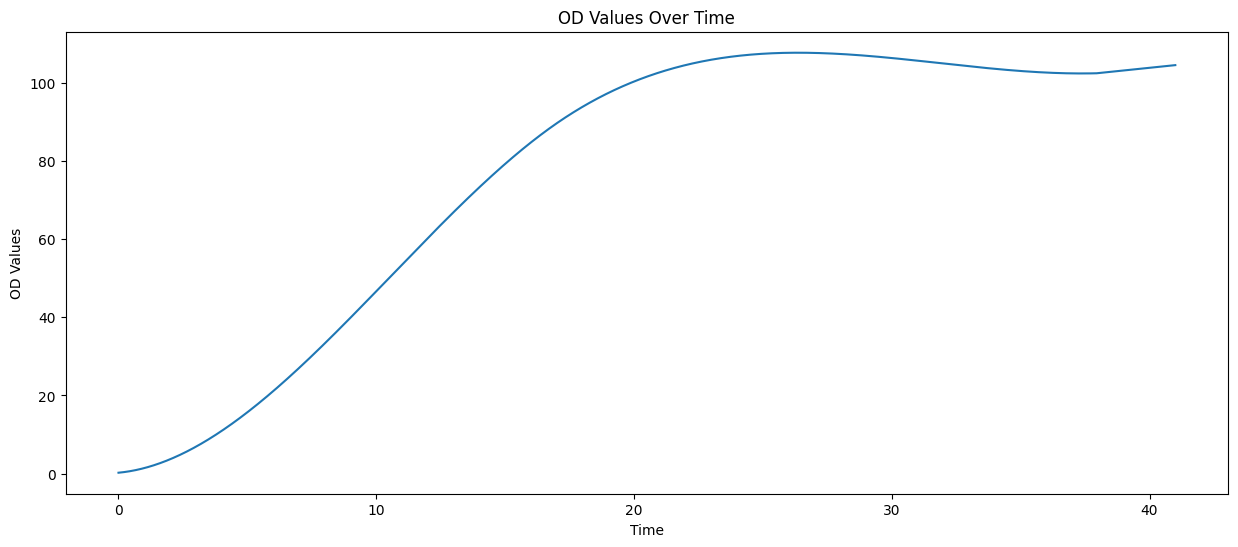

In [ ]:
# Extract time points and OD values

# Create the plot
plt.figure(figsize=(15, 6))  # Adjust figure size as needed
plt.plot(timestamps, m_interpol_OD)
plt.xlabel('Time')
plt.ylabel('OD Values')
plt.title('OD Values Over Time')
#plt.grid(True)
plt.show()

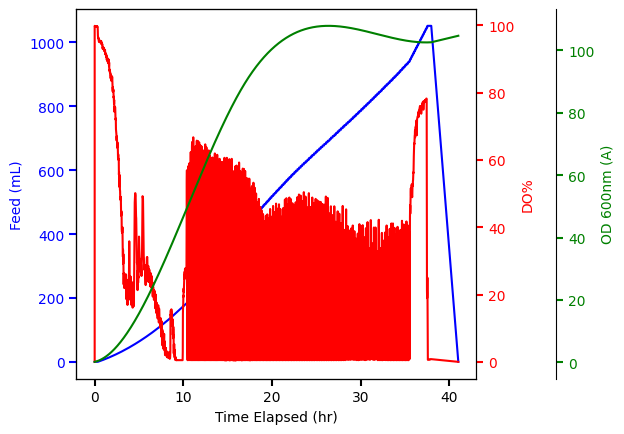

In [ ]:
def multi_axis_plot (timestamps, dm_feed, m_do, m_interpol_OD):

  # Below is the code required to present a multi axis trace with the
  # interpolated OD values
  fig, ax = plt.subplots()
  fig.subplots_adjust(right=0.75)
  twin1 = ax.twinx()
  twin2 = ax.twinx()

  # Offset the right spine of twin2.  The ticks and label have already been
  # placed on the right by twinx above.

  twin2.spines.right.set_position(("axes", 1.2))
  p1, = ax.plot(timestamps, dm_feed, "b-", label="Feed")
  p2, = twin1.plot(timestamps, m_do, "r-", label="DO")
  p3, = twin2.plot(timestamps, m_interpol_OD, "g-", label="OD")

  ax.set_xlabel("Time Elapsed (hr)")
  ax.set_ylabel("Feed (mL)")
  twin1.set_ylabel("DO%")
  twin2.set_ylabel("OD 600nm (A)")

  ax.yaxis.label.set_color(p1.get_color())
  twin1.yaxis.label.set_color(p2.get_color())
  twin2.yaxis.label.set_color(p3.get_color())

  tkw = dict(size=5, width=1.5)
  ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
  twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
  twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
  ax.tick_params(axis='x', **tkw)

  ax.xaxis.set_major_locator(MaxNLocator(5))

#Calling the above function suppling our current dataset
multi_axis_plot (timestamps, dm_feed, m_do, m_interpol_OD)

In this basic output plot of the OD values in combination with a couple of major over laid variabes. OD over time represents a sinusoidal curve which well matches other recorded bacterial growth curves.

The logistic growth model is described by the following differential equation:

$$
\frac{dN}{dt} = rN \left(1 - \frac{N}{K}\right)
$$

where:

- \( N \) is the population size (in this case, OD600).
- \( r \) is the intrinsic growth rate.
- \( K \) is the carrying capacity, the maximum population size that the environment can sustain.


Estimated parameters:
r = 0.2968807689623724
K = 106.20885023699972
N0 = 3.9125067628133117


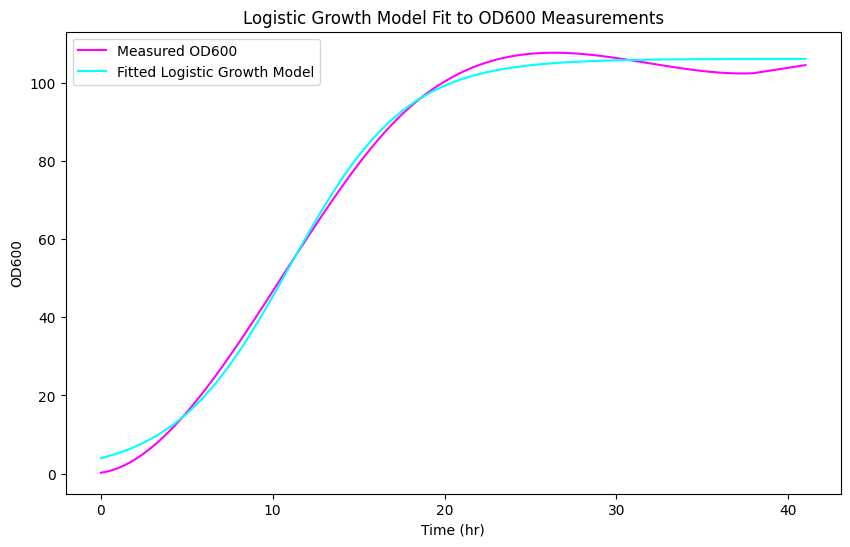

In [ ]:
time = timestamps
od600 = m_interpol_OD

# Setup and initialise logistic growth model
def logistic_growth(t, r, K, N0):
    return K / (1 + ((K - N0) / N0) * np.exp(-r * t))

# Initial guesses for r, K, and N0
initial_logistic_values = [0.3, 120, 0.2]

# Fit the logistic growth model
popt, _ = curve_fit(logistic_growth, time, od600, p0=initial_logistic_values)

# Extracting the parameters
r, K, N0 = popt
print(f"Estimated parameters:\nr = {r}\nK = {K}\nN0 = {N0}")

# Generate fitted OD600 values
original_time_fit = np.linspace(0, 41)
original_od600_fit = logistic_growth(original_time_fit, r, K, N0)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time, od600, label='Measured OD600', color='magenta')
plt.plot(original_time_fit, original_od600_fit, label='Fitted Logistic Growth Model', color='cyan')
plt.xlabel('Time (hr)')
plt.ylabel('OD600')
plt.legend()
plt.title('Logistic Growth Model Fit to OD600 Values')
plt.show()

In [ ]:
header = run_data_plus_header[0]

header = np.append(header, 'OD600')

In [ ]:
print(run_data)

[['0.0' '0.0' '0.0' ... '0.0' '0.0' '0.2']
 ['0.001027778' '99.80000305' '600' ... '0' '0' '0.20063933226396619']
 ['0.016722222' '99.69999695' '600' ... '0' '0' '0.21055622557830755']
 ...
 ['37.93352778' '0.800000012' '600' ... '0' '0' '102.51340319989467']
 ['37.95008333' '0.800000012' '600' ... '0' '0' '102.516082125174']
 ['41.0' '0.0' '0.0' ... '0.0' '0.0' '104.6']]


In [ ]:
output_2D_NParray(run_data)

Array saved to Output_ferm_data_with_OD.csv


In [ ]:
# Create DataFrame and add OD600 to it - use interpolated values
df_auto = pd.DataFrame(run_data, columns=header)

In [ ]:
print(df_auto)

        ﻿Time [h]     m_ham_do m_stirrer       m_temp      dm_feed  \
0             0.0          0.0       0.0          0.0          0.0   
1     0.001027778  99.80000305       600           30            0   
2     0.016722222  99.69999695       600           30            0   
3     0.033472222  99.69999695       600           30            0   
4         0.05025  99.59999847       600           30            0   
...           ...          ...       ...          ...          ...   
2275  37.90013889  0.800000012       600  11.89999962  1051.859985   
2276  37.91669444  0.800000012       600  11.69999981  1051.859985   
2277  37.93352778  0.800000012       600         11.5  1051.859985   
2278  37.95008333  0.800000012       600  11.39999962  1051.859985   
2279         41.0          0.0       0.0          0.0          0.0   

          dm_AIR1      dm_AIR2 dm_AIR3 dm_AIR4                OD600  
0             0.0          0.0     0.0     0.0                  0.2  
1     45970.55859  

In [ ]:
df_auto = df_auto.apply(pd.to_numeric, errors='coerce')

# Compute correlation matrix
correlation_matrix = df_auto.corr()

# Function to compute Pearson correlation and p-value
def pearson_corr_test(x, y):
    corr, p_value = pearsonr(x, y)
    return corr, p_value

# Calculate correlations and p-values
results = []
for column in df_auto.columns:
    if column != 'OD600':
        corr, p_value = pearson_corr_test(df_auto[column], df_auto['OD600'])
        results.append({'Variable': column, 'Correlation': corr, 'P-value': p_value})

# Create DataFrame to display results
results_df = pd.DataFrame(results)

# Display the correlation matrix and statistical test results
print("Correlation Matrix:\n", correlation_matrix)
print("\nCorrelation and P-values:\n", results_df)


Correlation Matrix:
            ﻿Time [h]  m_ham_do  m_stirrer    m_temp   dm_feed   dm_AIR1  \
﻿Time [h]   1.000000 -0.276512   0.612604 -0.165149  0.994932  0.996819   
m_ham_do   -0.276512  1.000000  -0.466893  0.084791 -0.241773 -0.274897   
m_stirrer   0.612604 -0.466893   1.000000  0.280034  0.585224  0.620254   
m_temp     -0.165149  0.084791   0.280034  1.000000 -0.151603 -0.135059   
dm_feed     0.994932 -0.241773   0.585224 -0.151603  1.000000  0.997555   
dm_AIR1     0.996819 -0.274897   0.620254 -0.135059  0.997555  1.000000   
dm_AIR2     0.996819 -0.274898   0.620251 -0.135067  0.997555  1.000000   
dm_AIR3          NaN       NaN        NaN       NaN       NaN       NaN   
dm_AIR4          NaN       NaN        NaN       NaN       NaN       NaN   
OD600       0.902168 -0.409486   0.800478 -0.061031  0.897306  0.901193   

            dm_AIR2  dm_AIR3  dm_AIR4     OD600  
﻿Time [h]  0.996819      NaN      NaN  0.902168  
m_ham_do  -0.274898      NaN      NaN -0.409486  
m_s

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


<Axes: >

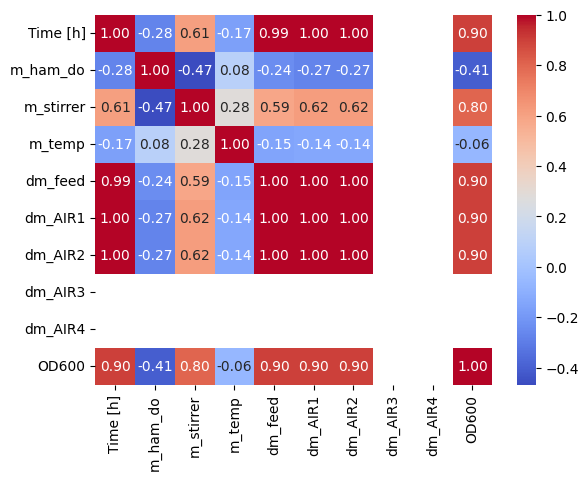

In [ ]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

In [ ]:
print(len(timestamps))
print(len(m_interpol_OD))

2280
2280


Degree Centrality: {'dm_feed': 1.0, 'dm_AIR1': 0.6666666666666666, 'm_ham_do': 0.6666666666666666, 'OD600': 1.0}
Betweenness Centrality: {'dm_feed': 0.16666666666666666, 'dm_AIR1': 0.0, 'm_ham_do': 0.0, 'OD600': 0.16666666666666666}


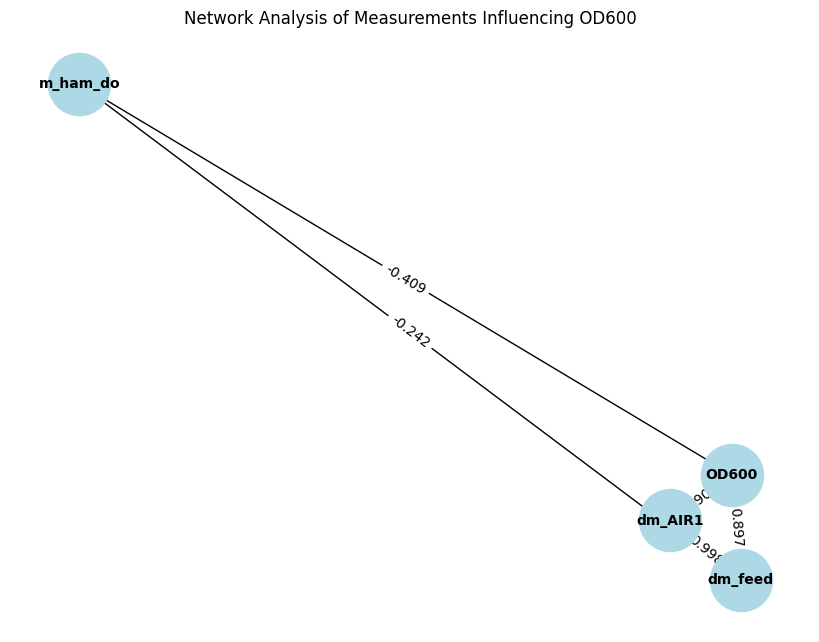

In [ ]:
#This function is used below to call the correlation coefficients out of the dataframe (df)
def call_correlation_coefficient (matrix, attribute1, attribute2):
  return round(float(matrix.loc[str(attribute1), str(attribute2)]),3)

# Network Analysis
def construct_network():
    # Create a directed graph
    G = nx.Graph()

    # Add nodes for each measurement - four chosen randomly by me
    nodes = ['dm_feed', 'dm_AIR1', 'm_ham_do', 'OD600']
    G.add_nodes_from(nodes)

    # Add edges with weights (from correlation)
    # set a threshold for correlation to decide if an edge should be present
    # Here I use arbitrary weights for demonstration - these could be the correlation coefficients, for example
    G.add_edge('dm_feed', 'OD600', weight=call_correlation_coefficient(correlation_matrix, "dm_feed", 'OD600'))
    G.add_edge('dm_AIR1', 'OD600', weight=call_correlation_coefficient(correlation_matrix, 'dm_AIR1', 'OD600'))
    G.add_edge('m_ham_do', 'OD600', weight=call_correlation_coefficient(correlation_matrix, 'm_ham_do', 'OD600'))
    G.add_edge('dm_feed', 'dm_AIR1', weight=call_correlation_coefficient(correlation_matrix, 'dm_feed', 'dm_AIR1'))
    G.add_edge('dm_feed', 'm_ham_do', weight=call_correlation_coefficient(correlation_matrix, 'dm_feed', 'm_ham_do'))

    return G

def analyze_network(G):
    # Compute centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    return degree_centrality, betweenness_centrality

# Construct and analyze the network
G = construct_network()
degree_centrality, betweenness_centrality = analyze_network(G)

print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)

# Plotting the network
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Network Analysis of Measurements Influencing OD600')
plt.show()

0.2


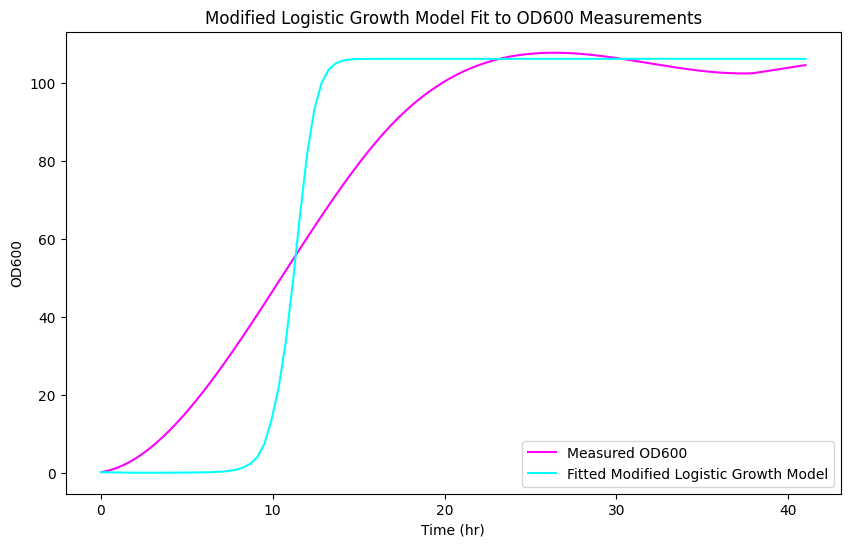

Fitted parameters:
r0 = 0.5138150808062685
a = 0.006703119840757738
b = -0.01430578898612498
c = 0.003552248263866763


In [ ]:
# Modified logistic growth model
def growth_rate(t, dm_feed, dm_AIR1, m_do, r0, a, b, c):
    return r0 + a * dm_feed + b * dm_AIR1 + c * m_do

def modified_logistic_growth(N, t, K, r0, a, b, c, dm_feed, dm_AIR1, m_do, timestamps):
    # Interpolate the automated measurements at the given time point
    dm_feed_t = np.interp(t, timestamps, dm_feed)
    dm_AIR1_t = np.interp(t, timestamps, dm_AIR1)
    m_do_t = np.interp(t, timestamps, m_do)
    m_stir_t = np.interp(t, timestamps, m_stir)


    r0 = r0 + a * dm_feed_t + b * m_do_t - c
    dNdt = r0 * N * (1 - N / K)
    return dNdt


# Automated measurements data - find better way to handle this
OD600_initial = float(m_interpol_OD[0])
print(OD600_initial)


# Fit the modified logistic growth model
def fit_modified_logistic_growth(params, timestamps, initial_N):
    r0, a, b, c = params
    sol = odeint(modified_logistic_growth, initial_N, timestamps, args=(K, r0, a, b, c, dm_feed, dm_AIR1, m_do, timestamps))
    return sol.ravel()


# Define objective function to minimize
def objective(params):
    sol = fit_modified_logistic_growth(params, timestamps, OD600_initial)
    #print("Shape of sol:", sol.shape)
    #print("Shape of od600:", od600.shape)
    return np.sum((sol - m_interpol_OD) ** 2)



# Initial guesses for the parameters of the modified model
initial_guesses_modified = [0.5, 0.01, 0.01, -0.01]

# Minimize the objective function
result = minimize(objective, initial_guesses_modified, method='L-BFGS-B')
fitted_params = result.x

# Generate fitted OD600 values using the fitted parameters
time_fit = np.linspace(0, 41, 100)
fitted_sol_full = odeint(modified_logistic_growth, OD600_initial, time_fit, args=(K, *fitted_params, dm_feed, dm_AIR1, m_do, timestamps)).ravel()



# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time, od600, label='Measured OD600', color='magenta')
plt.plot(time_fit, fitted_sol_full, label='Fitted Modified Logistic Growth Model', color='cyan')
plt.xlabel('Time (hr)')
plt.ylabel('OD600')
plt.legend()
plt.title('Modified Logistic Growth Model Fit to OD600 Measurements')
plt.show()

# Output the fitted parameters
print("Fitted parameters:")
print(f"r0 = {fitted_params[0]}")
print(f"a = {fitted_params[1]}")
print(f"b = {fitted_params[2]}")
print(f"c = {fitted_params[3]}")


^^^ Failed to fit adapted model to actual values

In [ ]:
# Logistic growth model parameters - from the ones fitted above, would need to be changed
r0 = 0.4486
K = 105.4
N0 = 0.3173
a = 0.0100
b = 0.0100
c = -0.0100

# Automated measurements data (subset for fitting)
time_points = np.array([2.300111, 16, 17, 22.25, 41])
dm_feed = np.array([8.52, 14.8, 15.27, 21.23, 28.01])
dm_AIR1 = np.array([183607, 211605.9, 213606, 238621.8, 265620.9])
m_ham_do = np.array([76.3, 52.7, 54.9, 29.8, 21.4])


# Modified logistic growth model
def growth_rate(t, dm_feed, dm_AIR1, m_ham_do, r0, a, b, c):
    return r0 + a * dm_feed + b * dm_AIR1 + c * m_ham_do


def modified_logistic_growth(N, t, K, r0, a, b, c, dm_feed, dm_AIR1, m_ham_do, time_points):
    # Interpolate the automated measurements at the given time point
    dm_feed_t = np.interp(t, time_points, dm_feed)
    dm_AIR1_t = np.interp(t, time_points, dm_AIR1)
    m_ham_do_t = np.interp(t, time_points, m_ham_do)

    # Compute the growth rate
    r = r0 + a * dm_feed_t + b * dm_AIR1_t + c * m_ham_do_t
    dNdt = r * N * (1 - N / K)
    return dNdt


# Function to classify the growth phase based on OD600
def classify_growth_phase(OD600, time_points, dm_feed, dm_AIR1, m_ham_do, K, r0, a, b, c):
    # Compute the growth rate at given OD600

    def growth_phase_derivative(N, t):
        return modified_logistic_growth(N, t, K, r0, a, b, c, dm_feed, dm_AIR1, m_ham_do, time_points)

    t = 0  # Arbitrary choice, as we're interested in the derivative at given OD600
    growth_rate_value = growth_phase_derivative(OD600, t)

    # Classify based on the growth rate and OD600 value
    if OD600 < 0.1 * K:
        phase = 'Lag Phase'
    elif growth_rate_value > 0.1 * np.max(np.abs(growth_rate_value)):
        phase = 'Exponential Phase'
    else:
        phase = 'Stationary Phase'

    return phase

# Example OD600 values for classification
example_OD600_values = [10, 50, 90]

# Classify and print the growth phase for each example OD600 value
for OD600 in example_OD600_values:
    phase = classify_growth_phase(OD600, time_points, dm_feed, dm_AIR1, m_ham_do, K, r0, a, b, c)
    print(f"OD600: {OD600}, Growth Phase: {phase}")


OD600: 10, Growth Phase: Lag Phase
OD600: 50, Growth Phase: Exponential Phase
OD600: 90, Growth Phase: Exponential Phase
